In [1]:
library(tidyverse)
library(stringr)
library(cowplot)
library(ggstance)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggstance’


The following objects are masked from ‘package:ggplot2’:

    geom_errorbarh, GeomErrorbarh




# Plotting
## Load Data

In [42]:
df <- read_csv("../Data/ODE_sim_Topt.csv", col_names = c("psw","N","temp","t","treat","T_opt","rep","drep")) %>%
    mutate(t = case_when(t == 1 ~ "initial", t == 2 ~ "dispersal",t == 3 ~ "kinetic")) %>%
    mutate(t = factor(t, levels = c("initial","dispersal","kinetic")))

#species data
sp_data <- read_csv("../Data/ODE_sp_Topt.csv", col_names = c("sp_id","location","temp","Tpk","n","M","c","r","mass","t","treat","T_opt","rep","drep")) %>%
    mutate(t = case_when(t == 1 ~ "initial", t == 2 ~ "dispersal",t == 3 ~ "kinetic")) %>%
    mutate(t = factor(t, levels = c("initial","dispersal","kinetic"))) %>%
    mutate(location = str_split(gsub("\\[|\\]", "", location),pattern = ","),
           temp = str_split(gsub("\\[|\\]", "", temp),pattern = ",")) %>%
    unnest(c(location, temp)) %>%
    mutate_at(vars(location,temp), as.numeric)

Rows: 937500 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): psw, N, temp, t, treat, T_opt, rep, drep

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 28125000 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): location, temp
dbl (12): sp_id, Tpk, n, M, c, r, mass, t, treat, T_opt, rep, drep

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [43]:
df <- df %>% arrange(rep,drep,treat,T_opt,t,temp) %>% group_by(rep,drep,treat,T_opt,t) %>% mutate(location = row_number())

In [44]:
sp_nest <- sp_data %>% filter(location != 0) %>% group_by(rep,drep,treat,T_opt,t,location) %>% nest()
df_nest <- df %>% group_by(rep,drep,treat,T_opt,t,location) %>% nest() %>% rename(com_data = data)

In [45]:
df_full <- full_join(sp_nest, df_nest) %>%
    unnest(c(data, com_data), names_sep = "_")

df_full <- df_full %>%  group_by(rep,drep,treat,T_opt,t,location) %>% mutate(uM_log = mean(log10(data_M)), uM = mean(data_M), uC = mean(data_c))

df_full %>% head()

Joining with `by = join_by(location, t, treat, T_opt, rep, drep)`


location,t,treat,T_opt,rep,drep,data_sp_id,data_temp,data_Tpk,data_n,data_M,data_c,data_r,data_mass,com_data_psw,com_data_N,com_data_temp,uM_log,uM,uC
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,initial,-0.75,0,1,1,1,1.159658,1.159658,0.83409383,22.591352,0.09630839,0.09897739,1,0.8,30,1.159658,0.7806482,10.71174,0.2988511
23,initial,-0.75,0,1,1,11,1.159658,1.159658,0.37052820,3.994474,0.09209675,0.03132512,1,0.8,30,1.159658,0.7806482,10.71174,0.2988511
23,initial,-0.75,0,1,1,38,1.159658,1.159658,0.60687886,9.663082,0.58176189,0.38816028,1,0.8,30,1.159658,0.7806482,10.71174,0.2988511
23,initial,-0.75,0,1,1,89,1.159658,1.159658,0.86007972,24.895669,0.35071999,0.56076074,1,0.8,30,1.159658,0.7806482,10.71174,0.2988511
23,initial,-0.75,0,1,1,107,1.159658,1.159658,0.37236750,4.022030,0.29020510,0.16411793,1,0.8,30,1.159658,0.7806482,10.71174,0.2988511
23,initial,-0.75,0,1,1,120,1.159658,1.159658,0.05174702,1.213384,0.02226058,0.01857857,1,0.8,30,1.159658,0.7806482,10.71174,0.2988511


## Fig 1) PSW over temperature

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


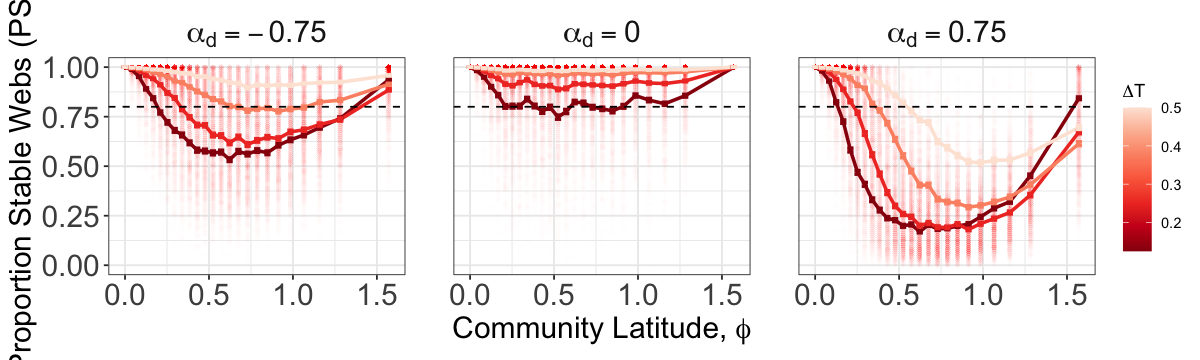

In [23]:
options(repr.plot.width=10, repr.plot.height=3)

dat_text <- data.frame(
  label = c("alpha[d] == -0.75 ","alpha[d] == 0 ","alpha[d] == 0.75 "),
  treat   = c(-0.75, 0.0, 0.75)
)


psw_plot <- df %>%
    filter(t == "dispersal", treat %in% c(0.75,0.0,-0.75), T_opt != 0.0) %>%
    mutate(group = paste("alpha[d]==",treat)) %>%
    ggplot(aes((temp), psw, group = T_opt, color = T_opt))+
        geom_point(alpha=0.005)+
        stat_summary(geom = "line", fun = "mean", linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        geom_hline(yintercept = 0.8, linetype = "dashed")+            
        theme_bw()+
        facet_wrap(~group,labeller = labeller(group = label_parsed))+
        xlab(expression(paste("Community Latitude, ",phi)))+
        ylab("Proportion Stable Webs (PSW)")+
        theme(axis.text = element_text(size = 18), strip.text = element_text(size = 18), strip.background = element_blank(), panel.spacing = unit(2, "lines"),axis.title = element_text(size=18))+
        scale_color_distiller(palette = "Reds", name = expression(paste(Delta,T)))

ggsave("../Figures/f1_psw.pdf", psw_plot, width = 12, height = 4)

psw_plot

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


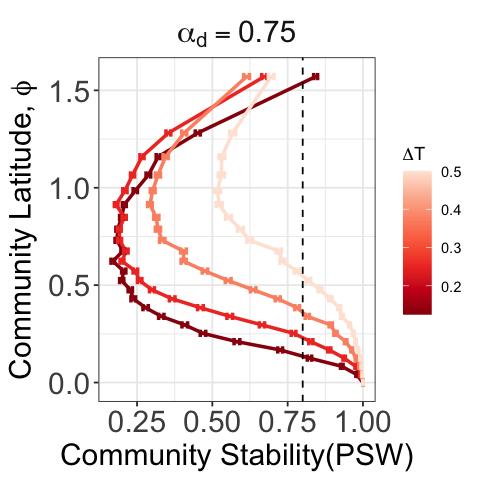

In [24]:
options(repr.plot.width=4, repr.plot.height=4)

dat_text <- data.frame(
  label = c("alpha[d] == -0.75 ","alpha[d] == 0 ","alpha[d] == 0.75 "),
  treat   = c(-0.75, 0.0, 0.75)
)


psw_plot <- df %>%
    filter(t == "dispersal", treat == 0.75, T_opt != 0.0) %>%
    mutate(group = paste("alpha[d]==",treat)) %>%
    ggplot(aes((temp), psw, group = T_opt, color = T_opt))+
        # geom_point(alpha=0.005)+
        stat_summary(geom = "line", fun = "mean", linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        geom_hline(yintercept = 0.8, linetype = "dashed")+            
        theme_bw()+
        facet_wrap(~group,labeller = labeller(group = label_parsed))+
        xlab(expression(paste("Community Latitude, ",phi)))+
        ylab("Community Stability(PSW)")+
        theme(axis.text = element_text(size = 18), strip.text = element_text(size = 18), strip.background = element_blank(), panel.spacing = unit(2, "lines"),axis.title = element_text(size=18))+
        scale_color_distiller(palette = "Reds", name = expression(paste(Delta,T)))+
        coord_flip()

ggsave("../Figures/f1_psw_abstract.pdf", psw_plot, width = 5, height = 4)

psw_plot

## Fig 2) N over temperature

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


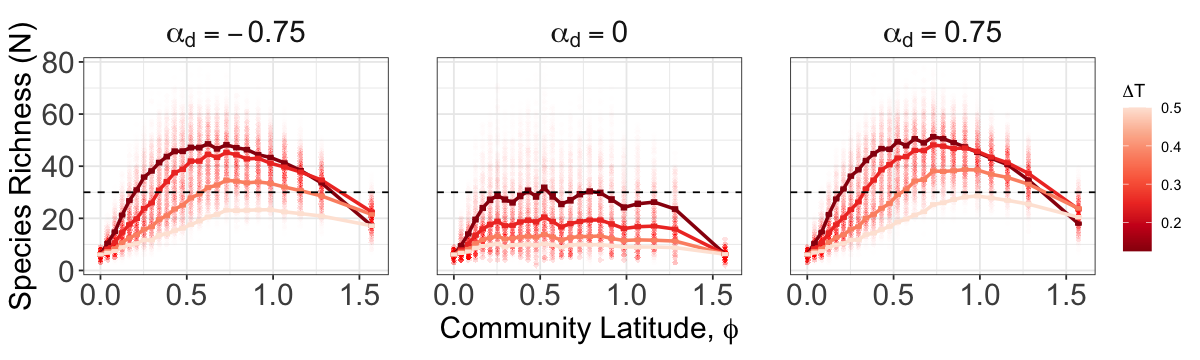

In [25]:
options(repr.plot.width=10, repr.plot.height=3)

dat_text <- data.frame(
  label = c("alpha[d] == -0.75","alpha[d] == 0","alpha[d] == 0.75"),
  treat   = c(-0.75, 0.0, 0.75)
)

psw_plot <- df %>%
    filter(t == "dispersal", treat %in% c(0.75,0.0,-0.75), T_opt != 0.0) %>%
    mutate(group = paste("alpha[d]==",treat)) %>%
    ggplot(aes((temp), N, group = T_opt, color = T_opt))+
        geom_point(alpha=0.005)+
        stat_summary(geom = "line", fun = "mean", linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        geom_hline(yintercept = 30, linetype = "dashed")+            
        # geom_smooth(se = FALSE)+
        theme_bw()+
        facet_wrap(~group,labeller = labeller(group = label_parsed))+
        xlab(expression(paste("Community Latitude, ",phi)))+
        ylab("Species Richness (N)")+
        theme(axis.text = element_text(size = 18), strip.text = element_text(size = 18),strip.background = element_blank(), panel.spacing = unit(2, "lines"),axis.title = element_text(size=18))+
        scale_color_distiller(palette = "Reds", name = expression(paste(Delta,T)))


ggsave("../Figures/f2_N.pdf", psw_plot, width = 12, height = 4)

psw_plot

In [10]:
df_com <- df_full %>%
    filter(t == "dispersal", com_data_psw > 0, com_data_psw < 1) %>%
    select(location,t,treat,rep,drep,com_data_temp,com_data_psw,com_data_N,uM, uM_log) %>%
    distinct()

Adding missing grouping variables: `T_opt`


No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


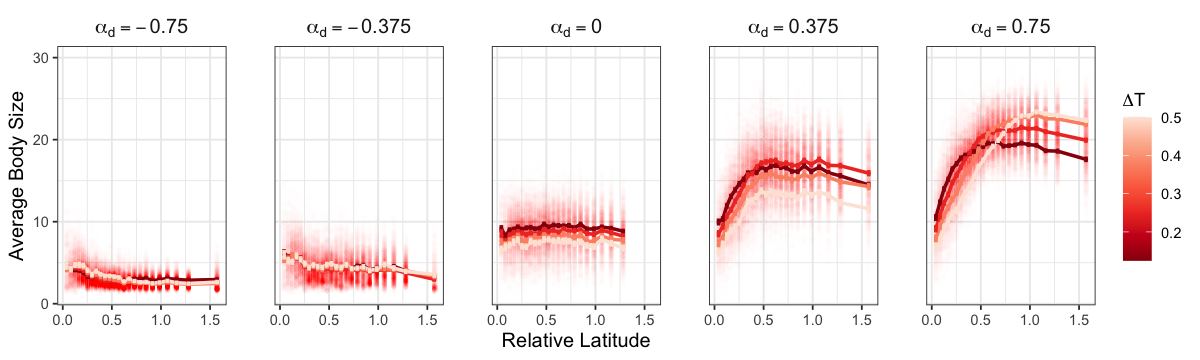

In [31]:
options(repr.plot.width=10, repr.plot.height=3)

l <- paste("alpha[d]==",seq(-0.75,0.75,length.out = 5))

bs_lat <- df_com %>%
     filter( T_opt != 0.0) %>%
        mutate(group = paste("alpha[d]==",treat)) %>%
        mutate(group = factor(group, levels = l)) %>%
        ggplot(aes((com_data_temp), (uM), color = T_opt, group = paste(treat,T_opt)))+
        geom_point(alpha=0.005)+
        stat_summary(geom = "line", fun = "mean" , linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        facet_wrap(~group, labeller = labeller(group = label_parsed), nrow = 1)+
        theme_bw()+
        xlab("Relative Latitude")+
        ylab("Average Body Size")+
        scale_color_distiller(palette = "Reds", name = expression(paste(Delta,T)))+
        theme(strip.text = element_text(size = 12),strip.background = element_blank(), panel.spacing = unit(2, "lines"),axis.title = element_text(size=12))

bs_lat

# N vs psw - accounting for the difference

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


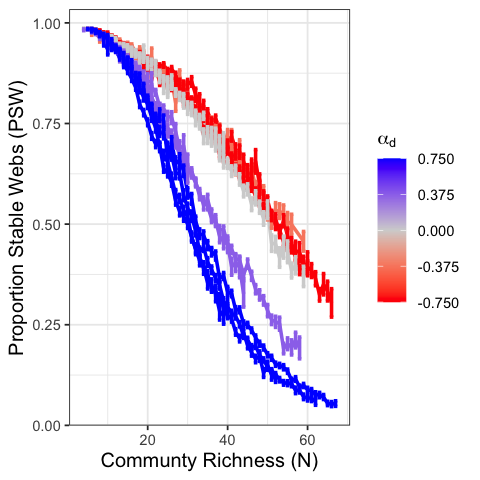

In [32]:
options(repr.plot.width=4, repr.plot.height=4)


N_psw <- df_com %>% 
    filter(t == "dispersal", T_opt != 0.0) %>%
    # filter(com_data_psw > 0.0, com_data_psw < 1.0) %>% 
    # mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    group_by(com_data_N,treat,T_opt) %>%
    filter(n() > 20) %>%
    ggplot(aes(com_data_N, com_data_psw, group = paste(treat,T_opt), color = treat)) +
        # geom_point(alpha = 0.005)+
        stat_summary(geom = "line", fun = "mean", linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        theme_bw()+
        scale_color_gradient2(low = "red", high = "blue", mid = "lightgrey", name = expression(paste(alpha[d])), breaks = seq(-0.75,0.75,length.out = 5))+
        theme(axis.title = element_text(size=12))+
        xlab("Communty Richness (N)")+
        ylab("Proportion Stable Webs (PSW)")

ggsave("../Figures/f3_N_psw.pdf", N_psw, width = 4, height = 3)

N_psw

In [16]:
# df_com %>%
#     filter(t == "dispersal", T_opt != 0.0) %>%
#     group_by(treat,T_opt) %>%
#     filter(n() > 20) %>%
#     nest() %>%
#     mutate(mod = map(data, ~glm(data=.x, com_data_psw ~ com_data_N,family = quasibinomial)))
    

In [17]:
# df_full %>%
#     select(location,t,treat,rep,drep,psw = com_data_psw,N = com_data_N,uM) %>%
#     distinct() %>%
#     filter(t == "dispersal") %>%
#     filter(psw > 0.0, psw < 1.0) %>% 
#     mutate(odds = log(psw / (1 - psw)), uM_cut = cut(uM, 10)) %>%
#     group_by(N, uM_cut)
#     # filter(n() > 10) %>%
#     # summarise(m_psw = mean(psw), m_odds = mean(odds), uM = mean(uM)) %>%
#     # ggplot(aes(N, psw, color = uM, group = uM))+
#     #     geom_point()


Warning message:
“There were 6 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cor = cor(uM, com_data_psw)`.
ℹ In group 1: `com_data_N = 2`, `T_opt = 0`.
Caused by warning in `cor()`:
! the standard deviation is zero
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”
`summarise()` has grouped output by 'com_data_N'. You can override using the `.groups` argument.
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


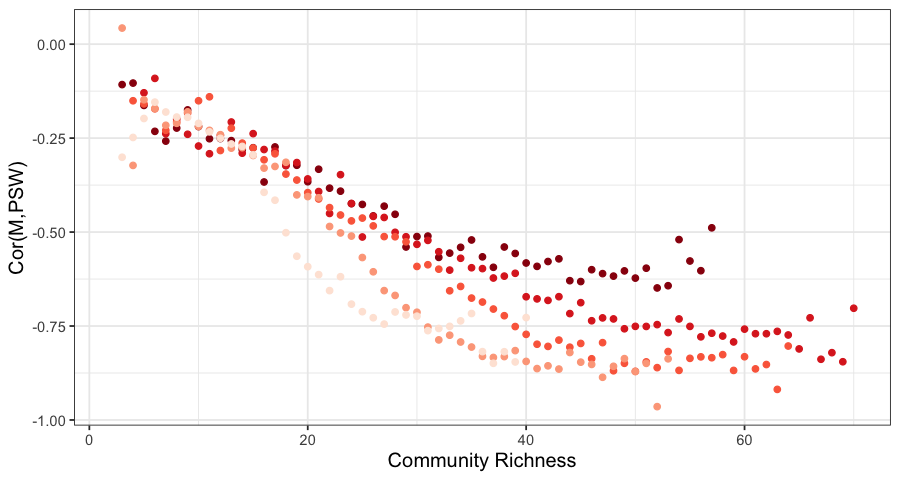

In [33]:
options(repr.plot.width=7.5, repr.plot.height=4)

cor_plot <- df_full %>%
    select(location,t,treat,rep,drep,com_data_psw,com_data_N,uM, T_opt) %>%
    distinct() %>%
    filter(t == "dispersal") %>%    
    ungroup %>%
    group_by(com_data_N, T_opt) %>%
    filter(n() > 20) %>%
    summarise(cor = cor(uM,com_data_psw)) %>%
    ggplot(aes(com_data_N, cor, color = T_opt))+
        geom_point()+
        theme_bw()+
        theme(legend.position = "none", axis.title = element_text(size=12)) + 
        scale_color_distiller(palette = "Reds", name = expression(paste(Delta,T)))+
        xlab("Community Richness")+
        ylab("Cor(M,PSW)")

cor_plot

No summary function supplied, defaulting to `mean_se()`
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


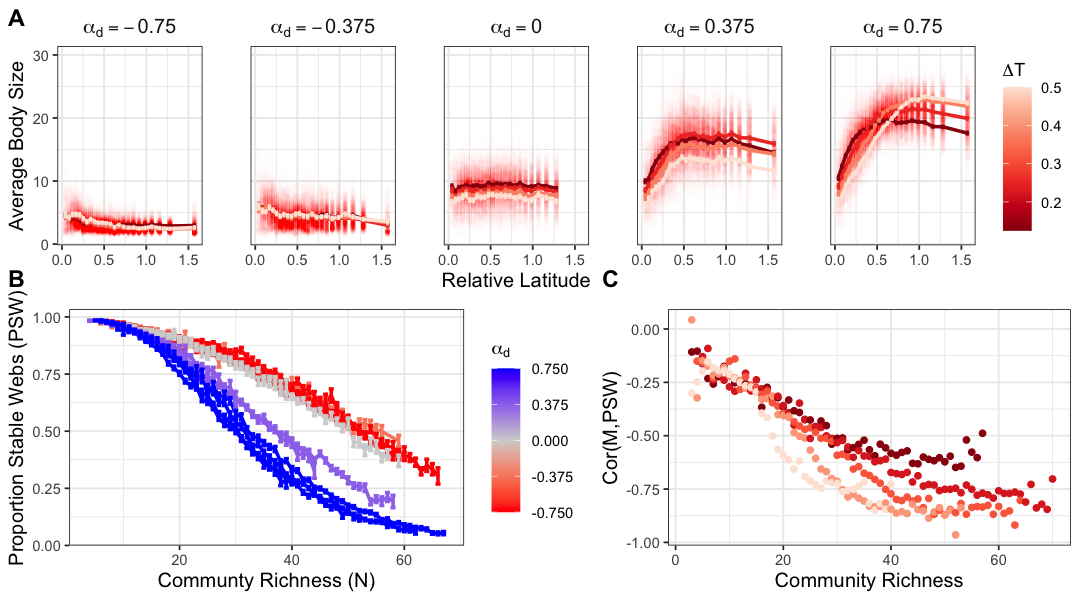

In [37]:
options(repr.plot.width=9, repr.plot.height=5)
size_plot <- plot_grid(N_psw, cor_plot, rel_widths = c(0.55,0.45), labels = LETTERS[2:3], vjust = -0.8)
full_plot <- plot_grid(bs_lat, size_plot, nrow = 2, labels = c("A",""))
full_plot

In [38]:
ggsave("../Figures/f4_size.pdf", full_plot, width = 9, height = 5)


In [62]:
head(df_full)

location,t,treat,T_opt,rep,drep,data_sp_id,data_temp,data_Tpk,data_n,data_M,data_c,data_r,data_mass,com_data_psw,com_data_N,com_data_temp,uM_log,uM
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,initial,-0.75,0,1,1,1,1.159658,1.159658,0.83409383,22.591352,0.09630839,0.09897739,1,0.8,30,1.159658,0.7806482,10.71174
23,initial,-0.75,0,1,1,11,1.159658,1.159658,0.37052820,3.994474,0.09209675,0.03132512,1,0.8,30,1.159658,0.7806482,10.71174
23,initial,-0.75,0,1,1,38,1.159658,1.159658,0.60687886,9.663082,0.58176189,0.38816028,1,0.8,30,1.159658,0.7806482,10.71174
23,initial,-0.75,0,1,1,89,1.159658,1.159658,0.86007972,24.895669,0.35071999,0.56076074,1,0.8,30,1.159658,0.7806482,10.71174
23,initial,-0.75,0,1,1,107,1.159658,1.159658,0.37236750,4.022030,0.29020510,0.16411793,1,0.8,30,1.159658,0.7806482,10.71174
23,initial,-0.75,0,1,1,120,1.159658,1.159658,0.05174702,1.213384,0.02226058,0.01857857,1,0.8,30,1.159658,0.7806482,10.71174


In [76]:
extinctions <- df_full %>% 
    filter(t == "dispersal") %>%
    group_by(data_sp_id, treat, T_opt, rep, drep, data_Tpk) %>%
    summarise(ext = sum((location > 0) * com_data_psw)) %>%
    ungroup %>%
    group_by(treat, T_opt, rep, drep, data_Tpk) %>%
    summarise(p_tot = sum(ext)) 

extinctions %>% head()

`summarise()` has grouped output by 'data_sp_id', 'treat', 'T_opt', 'rep', 'drep'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'treat', 'T_opt', 'rep', 'drep'. You can override using the `.groups` argument.


treat,T_opt,rep,drep,data_Tpk,p_tot
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.75,0,1,1,0.00000000,18.01
-0.75,0,1,1,0.04167873,34.86
-0.75,0,1,1,0.08343009,16.97
-0.75,0,1,1,0.12532783,29.10
-0.75,0,1,1,0.16744808,30.47
-0.75,0,1,1,0.20987059,38.18


In [70]:
extinctions %>%
    filter(treat %in% c(-0.75,0.0,0.75)) %>%
    ggplot(aes(Tpk,`FALSE` / 30, color = T_opt, group = T_opt))+
        stat_summary(geom = 'line', fun = 'mean')+
        facet_wrap(~treat)

ERROR while rich displaying an object: Error in `stat_summary()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'Tpk' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)

Adding missing grouping variables: `rep`, `drep`, `treat`, `T_opt`, `t`, `location`


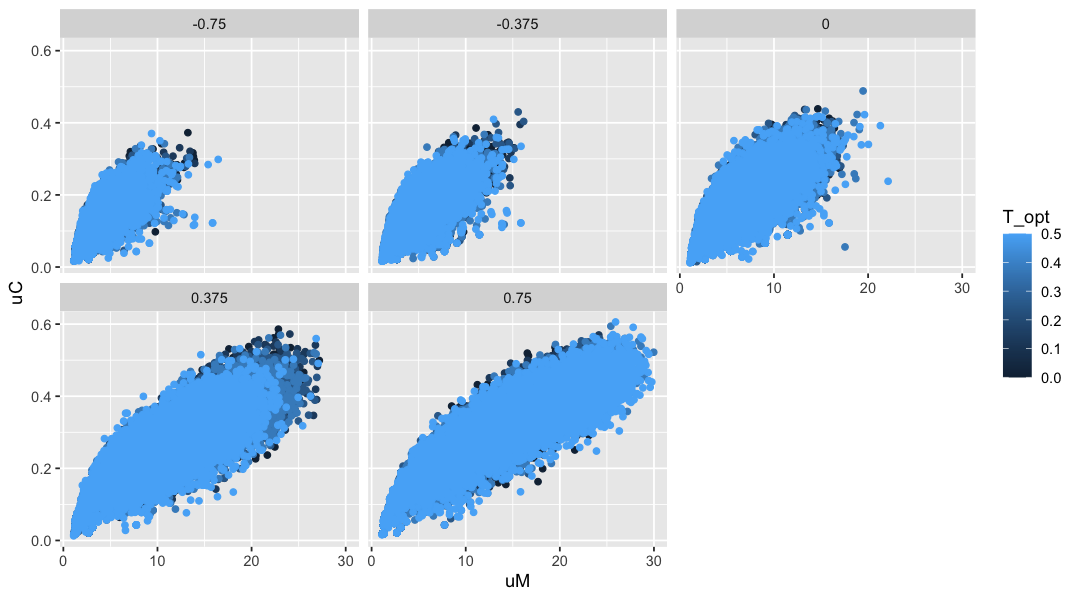

In [51]:
df_full %>% 
     filter(t == "dispersal") %>% 
        select(uC,uM) %>%
        distinct() %>%
        ggplot(aes(x=uM, y = uC, color = T_opt))+
            geom_point()+
            facet_wrap(~treat)

Warning message:
“There were 6 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cor = cor(uC, com_data_psw)`.
ℹ In group 1: `com_data_N = 2`, `T_opt = 0`.
Caused by warning in `cor()`:
! the standard deviation is zero
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”
`summarise()` has grouped output by 'com_data_N'. You can override using the `.groups` argument.
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


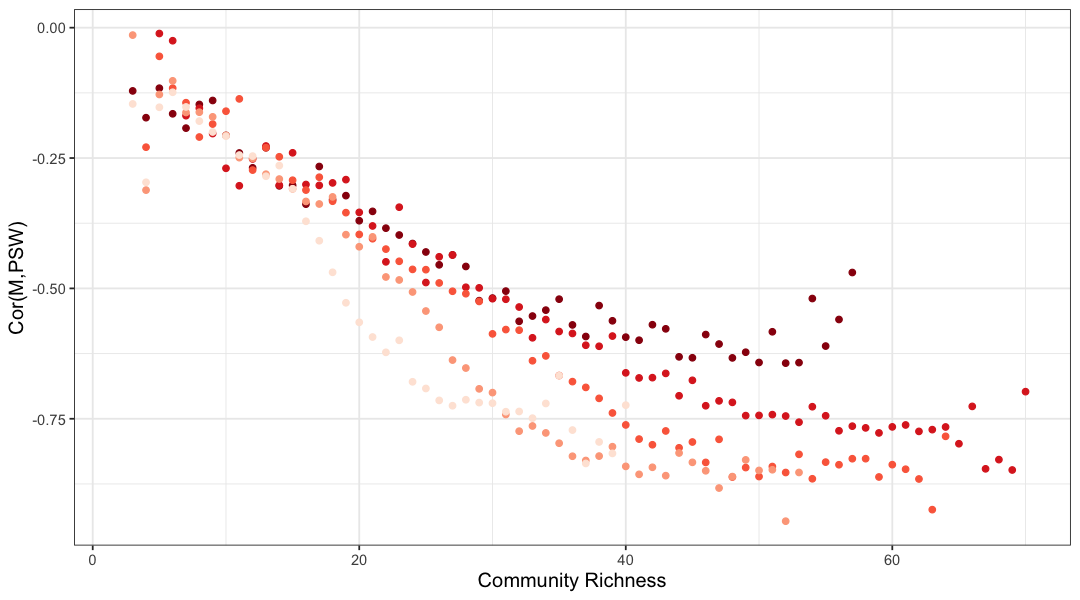

In [46]:
cor_plot <- df_full %>%
    select(location,t,treat,rep,drep,com_data_psw,com_data_N,uC, T_opt) %>%
    distinct() %>%
    filter(t == "dispersal") %>%    
    ungroup %>%
    group_by(com_data_N, T_opt) %>%
    filter(n() > 20) %>%
    summarise(cor = cor(uC,com_data_psw)) %>%
    ggplot(aes(com_data_N, cor, color = T_opt))+
        geom_point()+
        theme_bw()+
        theme(legend.position = "none", axis.title = element_text(size=12)) + 
        scale_color_distiller(palette = "Reds", name = expression(paste(Delta,T)))+
        xlab("Community Richness")+
        ylab("Cor(M,PSW)")

cor_plot

$$
N(t+1) = N(t)(1 + I) - R
$$